In [1]:
# %%
from functools import partial
import jax.numpy as jnp
import jax.random as random
from flax import optim
from modax.training import create_update, train_max_iter
from nf import AmortizedNormalizingFlow
from data import random_walk
import matplotlib.pyplot as plt
import seaborn as sns
from modax.layers.feature_generators.utils import vgrad_backward, vgrad_forward, nth_polynomial
import numpy as np
import jax
sns.set()

%load_ext autoreload
%autoreload 2

In [151]:
key = random.PRNGKey(42)
# %% Making sample dataset
def dataset(n_steps, n_walkers, D, v, dt, sigma0, x0):
    def initial_condition(loc, width, key, shape):
        return loc + width * random.normal(key, shape)
    ini = partial(initial_condition, x0, sigma0)
    locs, t = random_walk(key, ini, n_steps, n_walkers, D, v, dt=dt)
    
    return jnp.expand_dims(locs, -1), jnp.expand_dims(t, -1)

D = 0.5
v = 0.1
dt= 0.05
sigma0 =1.5
x0=-1

X, t = dataset(50, 100, 1.5, 0.1, 0.05, 0.5, -1)

In [3]:
def loss_fn(params, state, model, x):
    log_p = model.apply(params, x)
    loss = -jnp.sum(log_p)
    
    metrics = {"loss": loss}
    return loss, (state, metrics, (log_p))

In [119]:
model = AmortizedNormalizingFlow([100], 10)
params = model.init(key, (X, t))

In [120]:
model.apply(params, (X, t))[0].shape

(50, 1)

In [121]:
# %% Initializing model
optimizer_def = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)
optimizer = optimizer_def.create(params)

# Compiling train step
update = create_update(loss_fn, (model, (X, t)))

In [122]:
optimizer, _ = train_max_iter(update, optimizer, None, 10000)

Loss step 0: 118695.3203125
Loss step 500: 23040.87109375
Loss step 1000: 22715.2421875
Loss step 1500: 22520.626953125
Loss step 2000: 22406.46484375
Loss step 2500: 22362.6015625
Loss step 3000: 22340.6953125
Loss step 3500: 22320.0546875
Loss step 4000: 22307.828125
Loss step 4500: 22302.201171875
Loss step 5000: 22288.34765625
Loss step 5500: 22266.95703125
Loss step 6000: 22260.76953125
Loss step 6500: 22257.80859375
Loss step 7000: 22256.5703125
Loss step 7500: 22253.8671875
Loss step 8000: 22254.41796875
Loss step 8500: 22251.421875
Loss step 9000: 22250.12109375
Loss step 9500: 22250.666015625


In [123]:
# Reshaping for library
log_pz, log_jac = model.apply(optimizer.target, (X, t))
X_library = jnp.concatenate([(jnp.ones_like(X.squeeze()) * t).reshape(-1, 1), X.reshape(-1, 1)], axis=1)

ValueError: too many values to unpack (expected 2)

In [138]:
p, vjp_x = jax.vjp(lambda x: jnp.exp(model.apply(optimizer.target, (x, t))), X)

In [139]:
p_x = vjp_x(jnp.ones_like(p))[0]

<AxesSubplot:ylabel='Density'>

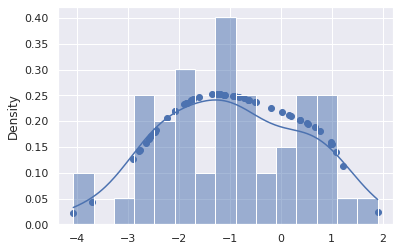

In [153]:
frame = 20
plt.scatter(X.squeeze()[frame, :], p.squeeze()[frame, :])
sns.histplot(X.squeeze()[frame, :], stat='density', kde=True, bins=15)

In [154]:
x = X.squeeze()[frame, :]
p_x_grad = np.gradient(p.squeeze()[frame, :], x)

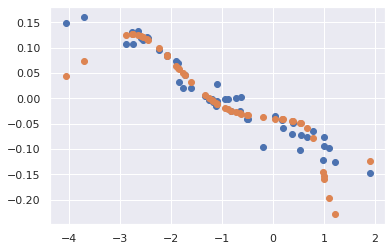

In [155]:
plt.scatter(x, p_x_grad)
plt.scatter(x, p_x.squeeze()[frame, :])

Seems correct... Now to try the time dependence:

In [156]:
p, vjp_t = jax.vjp(lambda x: jnp.exp(model.apply(optimizer.target, (X, x))), t)

In [157]:
x_slice = 10
v = jax.ops.index_update(jnp.zeros_like(p), jax.ops.index[:, x_slice], 1)

In [158]:
p_t_grad = np.gradient(p.squeeze()[:, x_slice], t.squeeze())

In [159]:
p_t = vjp_t(v)[0]

(-1.0, 1.0)

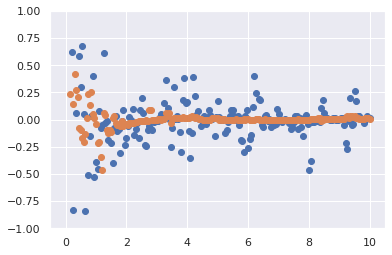

In [160]:
plt.scatter(t.squeeze(), p_t_grad)
plt.scatter(t.squeeze(), p_t.squeeze())

plt.ylim([-1, 1])

So we need to check on a grid to  be sure.

In [329]:
x = jnp.linspace(-10, 10, 500)
x_grid = jnp.meshgrid(x, t.squeeze())[0][:, :, None]

In [330]:
p, vjp_x = jax.vjp(lambda x: jnp.exp(model.apply(optimizer.target, (x, t))), x_grid)

In [331]:
p_x = vjp_x(jnp.ones_like(p))[0]
p = p.squeeze()

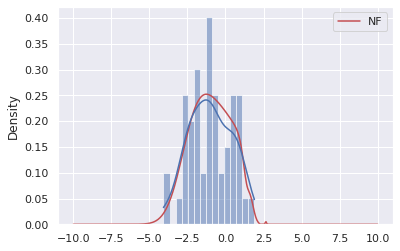

In [332]:
frame = 20
plt.plot(x_grid[frame, :], p[frame, :], color='r', label='NF')
sns.histplot(X[frame, :], stat='density', kde=True, bins=15)
plt.legend()

In [336]:
p_x_grad = jnp.gradient(p, x[1] - x[0], axis=1)

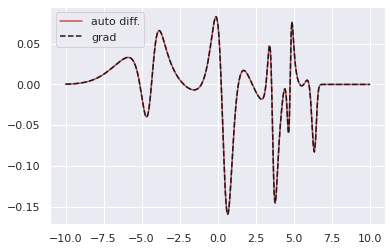

In [339]:
frame = 150
plt.plot(x, p_x_grad[frame, :], 'r', label='auto diff.')
plt.plot(x, p_x.squeeze()[frame, :], 'k--', label='grad')
plt.legend()

In [370]:
p, vjp_t = jax.vjp(lambda x: jnp.exp(model.apply(optimizer.target, (x_grid, x))), t)

In [371]:
p.shape

(201, 500, 1)

In [397]:
x_slice = 100
v = jax.ops.index_update(jnp.zeros_like(p), jax.ops.index[:, x_slice, :], 1)
#p = p.squeeze()

In [398]:
v.shape

(201, 500, 1)

In [399]:
p_t = vjp_t(v)[0]

In [400]:
p_t.shape

(201, 1)

In [401]:
dt = (t[1]- t[0]).squeeze()
p_t_grad = jnp.gradient(p, dt, axis=0)

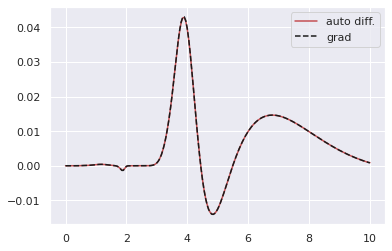

In [402]:
plt.plot(t, p_t_grad[:, x_slice], 'r', label='auto diff.')
plt.plot(t, p_t.squeeze(), 'k--', label='grad')
plt.legend()
#plt.ylim([-1, 1])

In [366]:
p_t.shape

(201, 1)

What if we do it with forward mdoe autodiff?

In [404]:
p, p_t = jax.jvp(lambda x: jnp.exp(model.apply(optimizer.target, (x_grid, x))), (t, ), (jnp.ones_like(t),))

In [406]:
p_t.shape

(201, 500, 1)

In [407]:
p_t_grad.shape

(201, 500, 1)

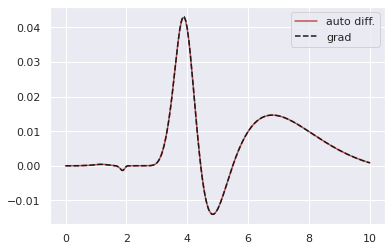

In [411]:
x_slice = 100
plt.plot(t, p_t_grad[:, x_slice], 'r', label='auto diff.')
plt.plot(t, p_t.squeeze()[:, x_slice], 'k--', label='grad')
plt.legend()
#plt.ylim([-1, 1])

... it works? Does that also work for th vjp:

In [420]:
p, vjp_t = jax.vjp(lambda x: jnp.exp(model.apply(optimizer.target, (x_grid, x))), t)

In [422]:
p.shape

(201, 500, 1)

In [423]:
p_t = vjp_t(jnp.ones_like(p))

In [ ]:
x_slice = 100
plt.plot(t, p_t_grad[:, x_slice], 'r', label='auto diff.')
plt.plot(t, p_t.squeeze()[:, x_slice], 'k--', label='grad')
plt.legend()
#plt.ylim([-1, 1])

So no....

Okay so forward for the time, backward for the coors:

In [426]:
df_x = lambda y: jax.vjp(lambda x: jnp.exp(model.apply(optimizer.target, (x, t))), y)[0]

In [427]:
df_x

<function __main__.<lambda>(y)>

In [447]:
f = lambda x, t: jnp.exp(model.apply(optimizer.target, (x, t)))

In [467]:
df_t = partial(vgrad_forward, lambda t: f(x_grid, t), input_idx=0)

df_x = partial(vgrad_backward, lambda x: f(x, t))
d2f_x = partial(vgrad_backward, df_x)
d3f_x = partial(vgrad_backward, d2f_x)

In [3]:
def NF_library(poly_order=2):
    def library_fn(model, inputs):
        X, t = inputs
        f = lambda x, t: jnp.exp(model((x, t)))

        # prediction
        pred = model(inputs).reshape(-1, 1)
        polynomials = poly_fn(jnp.exp(pred))
        # time deriv
        df_t = vgrad_forward(lambda t: f(X, t), t, input_idx=0).reshape(-1, 1)

        # spatial derivs
        df_x = partial(vgrad_backward, lambda x: f(x, t))
        d2f_x = partial(vgrad_backward, df_x)
        d3f_x = partial(vgrad_backward, d2f_x)
        derivs = jnp.concatenate([df_x(X).reshape(-1, 1), d2f_x(X).reshape(-1, 1), d3f_x(X).reshape(-1, 1)], axis=1)
        
        # library
        u = jnp.concatenate([jnp.ones_like(pred), polynomials], axis=1)[:, :, None]
        du = jnp.concatenate([jnp.ones_like(pred), derivs], axis=1)[:, None, :]
        n_features = 4 * (poly_order + 1)
        theta = jnp.matmul(u, du).reshape(-1, n_features)
        return pred, (df_t, theta)
    poly_fn = partial(nth_polynomial, order=poly_order)
    return library_fn

In [4]:
f = lambda inputs: model.apply(optimizer.target, inputs)

In [5]:
pred, (dt, theta) = NF_library()(f, (X, t))

NameError: name 'model' is not defined

In [6]:
theta.shape

NameError: name 'theta' is not defined

In [522]:
dt.shape

(10050, 1)

In [523]:
theta.shape

(10050, 12)

In [524]:
jnp.linalg.lstsq(theta, dt)

(DeviceArray([[ 5.2715521e+00],
              [-1.3574780e+01],
              [-9.9328308e+00],
              [ 5.9261352e-02],
              [-1.1181621e+01],
              [-1.0482353e+01],
              [ 8.2384087e+01],
              [-6.6570501e+00],
              [-1.2271946e+01],
              [-8.7324247e+00],
              [ 8.1531616e+01],
              [ 8.3824013e+01]], dtype=float32),
 DeviceArray([69441340.], dtype=float32),
 DeviceArray(6, dtype=int32),
 DeviceArray([1.19888037e+04, 2.14939667e+02, 1.02889915e+02,
              8.00560074e+01, 6.92657471e+01, 3.29232788e+01,
              1.24402657e+01, 9.45057106e+00, 2.96436596e+00,
              2.23531938e+00, 1.46924162e+00, 3.42210412e-01],            dtype=float32))

In [501]:
X.shape

(201, 50, 1)

Heujj it works.

In [7]:
def loss_fn(params, state, model, x):
    variables = {"params": params, **state}
    (log_p, dt, theta, coeffs), updated_state = model.apply(variables, x, mutable=list(state.keys()))
    loss = -jnp.sum(log_p)
    
    metrics = {"loss": loss}
    return loss, (updated_state, metrics, (log_p, ))

In [4]:
from modax.models import DeepmodBase
from modax.layers.regression import LeastSquares

In [9]:
model = DeepmodBase(AmortizedNormalizingFlow, ([100, ], 10, ), NF_library, (), LeastSquares, ())
optimizer_def = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)

In [10]:
variables = model.init(key, (X, t))
state, params = variables.pop("params")
optimizer = optimizer_def.create(params)
update_fn = create_update(loss_fn, (model, (X, t)))

In [11]:
optimizer, state = train_max_iter(update_fn, optimizer, state, 10000)

Loss step 0: 885092.0625
Loss step 500: 23252.87890625
Loss step 1000: 22698.396484375
Loss step 1500: 22453.28515625
Loss step 2000: 22386.830078125
Loss step 2500: 22324.8359375
Loss step 3000: 22293.1015625
Loss step 3500: 22269.244140625
Loss step 4000: 22249.1796875
Loss step 4500: 22230.109375
Loss step 5000: 22213.068359375
Loss step 5500: 22194.072265625
Loss step 6000: 22181.78515625
Loss step 6500: 22172.1953125
Loss step 7000: 22163.365234375
Loss step 7500: 22157.525390625
Loss step 8000: 22150.6796875
Loss step 8500: 22146.740234375
Loss step 9000: 22141.56640625
Loss step 9500: 22138.078125


In [12]:
x = jnp.linspace(-5, 5, 100)
x_grid = jnp.meshgrid(x, t.squeeze())[0][:, :, None]

In [13]:
log_p, dt, theta, coeff = model.apply({"params": optimizer.target, **state}, (x_grid, t))

In [14]:
p = jnp.exp(log_p).reshape(x_grid.shape)

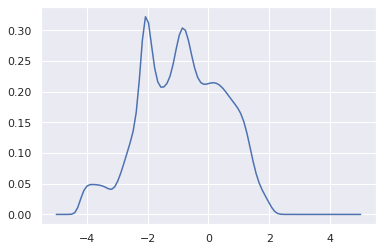

In [15]:
frame = 20
plt.plot(x, p[frame, :])

Oke now with a PINN:

In [5]:
from modax.training.losses.utils import mse, precision, normal_LL, gamma_LL

In [6]:
def loss_fn_regularized(params, state, model, x):
    n_samples = x[0].size
    prior_params_reg = (n_samples / 2, n_samples * 1e-6)
    
    variables = {"params": params, **state}
    (log_p, dt, theta, coeffs), updated_state = model.apply(variables, x, mutable=list(state.keys()))
    p_mse = jnp.sum(log_p)
    
    # Calculating precision of reg
    nu = precision(
        dt, theta @ coeffs, *prior_params_reg
    )  # calculates nu given gamma prior
    p_reg, reg = normal_LL(dt, theta @ coeffs, nu)
    p_reg += gamma_LL(nu, *prior_params_reg)  # adding priorr
    
    
    loss = -(p_mse + p_reg)
    
    metrics = {
        "loss": loss,
        "p_mse": p_mse,
        "p_reg": p_reg,
        "reg": reg,
        "coeff": coeffs,
    }
        
    return loss, (updated_state, metrics, (log_p, ))

In [40]:
model = DeepmodBase(AmortizedNormalizingFlow, ([30, 30], 10, ), NF_library, (), LeastSquares, ())
optimizer_def = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)

In [41]:
variables = model.init(key, (X, t))
state, params = variables.pop("params")
optimizer = optimizer_def.create(params)
update_fn = create_update(loss_fn_regularized, (model, (X, t)))

In [42]:
optimizer, state = train_max_iter(update_fn, optimizer, state, 10000)

Loss step 0: 1177100.25
Loss step 500: -76265.484375
Loss step 1000: -83496.03125
Loss step 1500: -85305.9296875
Loss step 2000: -88120.515625
Loss step 2500: -89772.90625
Loss step 3000: -90192.96875
Loss step 3500: -90523.5625
Loss step 4000: -90555.484375
Loss step 4500: -90886.796875
Loss step 5000: -91093.828125
Loss step 5500: -91020.0234375
Loss step 6000: -91220.046875
Loss step 6500: -91263.671875
Loss step 7000: -91296.6484375
Loss step 7500: -91244.625
Loss step 8000: -91446.34375
Loss step 8500: -91226.484375
Loss step 9000: -91378.21875
Loss step 9500: -91349.765625


In [43]:
x = jnp.linspace(-10, 10, 200)
x_grid = jnp.meshgrid(x, t.squeeze())[0][:, :, None]

In [44]:
log_p, dt, theta, coeffs = model.apply({'params': optimizer.target, **state}, (x_grid, t))

In [45]:
p = jnp.exp(log_p).reshape(x_grid.shape[:2])

<AxesSubplot:ylabel='Density'>

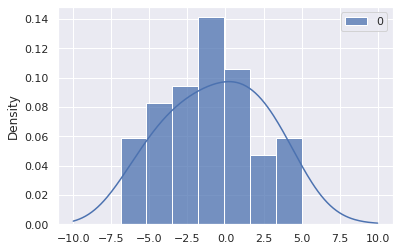

In [46]:
frame = 70
plt.plot(x, p[frame, :])
sns.histplot(X[frame, :], stat='density')

<AxesSubplot:>

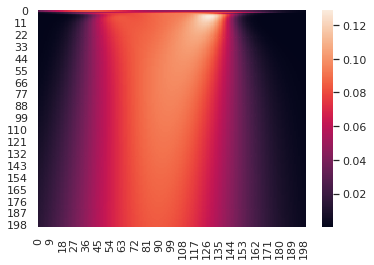

In [47]:
sns.heatmap(p)

In [50]:
def adv_diff(x, t, v, D, sigma0, x0):
    return  (2 * jnp.pi * sigma0 ** 2 + 4 * jnp.pi * D * t) ** (-1 / 2) * jnp.exp(
        -((x - x0 - v * t) ** 2) / (2 * sigma0 ** 2 + 4 * D * t)
    )

In [53]:
p_true = adv_diff(x_grid.squeeze(), jnp.ones_like(x_grid.squeeze()) * t, v, D, sigma0, x0)

<AxesSubplot:>

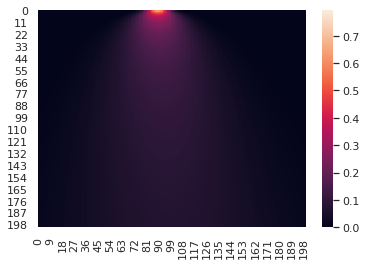

In [54]:
sns.heatmap(p_true)

In [55]:
p_true = adv_diff(x_grid.squeeze(), jnp.ones_like(x_grid.squeeze()) * t, v, D, sigma0, x0)

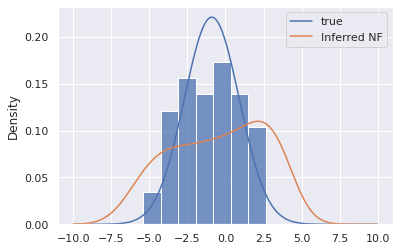

In [62]:
frame = 20
plt.plot(x, p_true[frame, :], label='true')
plt.plot(x, p[frame, :], label='Inferred NF')
sns.histplot(X[frame, :], stat='density')
plt.legend()

Now let's do it for a PINN:

In [254]:
def PINN_library():
    def library_fn(model, inputs):
        X, t = inputs
        f = lambda x, t: jnp.exp(model((x, t)))

        # prediction
        pred = model(inputs).reshape(-1, 1)
        # time deriv
        df_t = vgrad_forward(lambda t: f(X, t), t, input_idx=0).reshape(-1, 1)

        # spatial derivs
        df_x = partial(vgrad_backward, lambda x: f(x, t))
        d2f_x = partial(vgrad_backward, df_x)
        theta = jnp.concatenate([df_x(X).reshape(-1, 1), d2f_x(X).reshape(-1, 1)], axis=1)
        return pred, (df_t, theta)
    return library_fn


def loss_fn_regularized(params, state, model, x):
    n_samples = x[0].size
    prior_params_reg = (n_samples, n_samples * 1e-5)
    
    variables = {"params": params, **state}
    (log_p, dt, theta, coeffs), updated_state = model.apply(variables, x, mutable=list(state.keys()))
    p_mse = jnp.sum(log_p)
    
    # Calculating precision of reg
    nu = precision(
        dt, theta @ coeffs, *prior_params_reg
    )  # calculates nu given gamma prior
    p_reg, reg = normal_LL(dt, theta @ coeffs, nu)
    p_reg += gamma_LL(nu, *prior_params_reg)  # adding priorr
    
    
    loss = -(p_mse + p_reg)
    
    metrics = {
        "loss": loss,
        "p_mse": p_mse,
        "p_reg": p_reg,
        "reg": reg,
        "coeff": coeffs,
    }
        
    return loss, (updated_state, metrics, (log_p, ))

In [255]:
model = DeepmodBase(AmortizedNormalizingFlow, ([30, 30], 10, ), PINN_library, (), LeastSquares, ())
optimizer_def = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)

In [256]:
variables = model.init(key, (X, t))
state, params = variables.pop("params")
optimizer = optimizer_def.create(params)
update_fn = create_update(loss_fn_regularized, (model, (X, t)))

In [257]:
optimizer, state = train_max_iter(update_fn, optimizer, state, 20000)

Loss step 0: -45087.84375
Loss step 500: -67945.34375
Loss step 1000: -68115.0234375
Loss step 1500: -68329.875
Loss step 2000: -68372.765625
Loss step 2500: -68385.4296875
Loss step 3000: -68390.3984375
Loss step 3500: -68397.6015625
Loss step 4000: -68407.6953125
Loss step 4500: -68415.4375
Loss step 5000: -68415.875
Loss step 5500: -68411.96875
Loss step 6000: -68420.7265625
Loss step 6500: -68415.5703125
Loss step 7000: -68424.3125
Loss step 7500: -68428.3125
Loss step 8000: -68429.8984375
Loss step 8500: -68427.609375
Loss step 9000: -68423.0390625
Loss step 9500: -68434.4921875
Loss step 10000: -68425.6953125
Loss step 10500: -68432.0
Loss step 11000: -68427.8984375
Loss step 11500: -68433.125
Loss step 12000: -68429.703125
Loss step 12500: -68428.6640625
Loss step 13000: -68436.21875
Loss step 13500: -68442.1171875
Loss step 14000: -68439.40625
Loss step 14500: -68438.4296875
Loss step 15000: -68432.984375
Loss step 15500: -68434.5
Loss step 16000: -68433.09375
Loss step 16500: 

In [258]:
x = jnp.linspace(-10, 10, 200)
x_grid = jnp.meshgrid(x, t.squeeze())[0][:, :, None]

In [259]:
log_p, dt, theta, coeffs = model.apply({'params': optimizer.target, **state}, (x_grid, t))

In [260]:
p = jnp.exp(log_p).reshape(x_grid.shape[:2])

<AxesSubplot:ylabel='Density'>

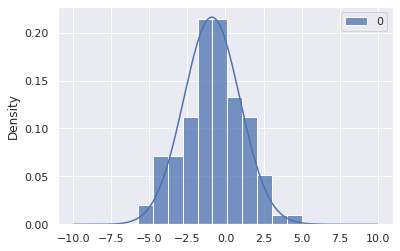

In [261]:
frame = 20
plt.plot(x, p[frame, :])
sns.histplot(X[frame, :], stat='density')

<AxesSubplot:>

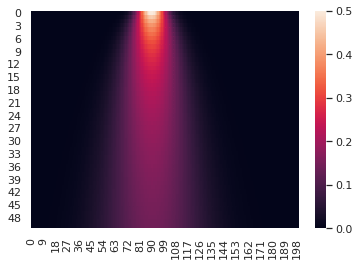

In [270]:
sns.heatmap(p, vmin=0, vmax=0.5)

In [263]:
def adv_diff(x, t, v, D, sigma0, x0):
    return  (2 * jnp.pi * sigma0 ** 2 + 4 * jnp.pi * D * t) ** (-1 / 2) * jnp.exp(
        -((x - x0 - v * t) ** 2) / (2 * sigma0 ** 2 + 4 * D * t)
    )

In [264]:
p_true = adv_diff(x_grid.squeeze(), jnp.ones_like(x_grid.squeeze()) * t, v, D, sigma0, x0)

<AxesSubplot:>

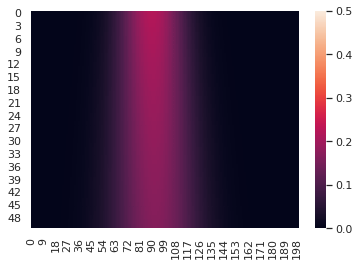

In [271]:
sns.heatmap(p_true, vmin=0, vmax=0.5)

In [266]:
p_true = adv_diff(x_grid.squeeze(), jnp.ones_like(x_grid.squeeze()) * t, v, D, sigma0, x0)

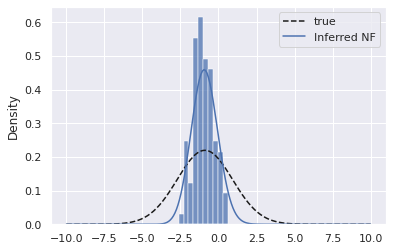

In [272]:
frame = 1
plt.plot(x, p_true[frame, :], 'k--', label='true')
plt.plot(x, p[frame, :], label='Inferred NF')
sns.histplot(X[frame, :], stat='density')
plt.legend()

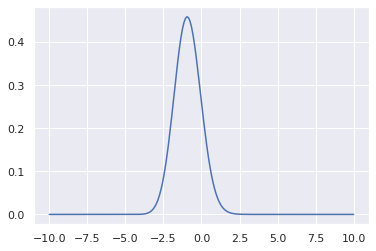

In [273]:
frame = 1
plt.plot(x, p[frame, :], label='Inferred NF')

frame = 1
plt.plot(x, p[frame, :], label='Inferred NF')

# SBL

In [231]:
X, t = dataset(50, 100, 1.5, 0.1, 0.05, 0.5, -1)
t += 1.0

In [232]:
from modax.linear_model.SBL import SBL

In [233]:
def loss_fn_SBL(params, state, model, x):
    model_state, loss_state = state
    n_samples = x[0].size
    beta_prior = (n_samples, n_samples * 1e-5)
    
    variables = {"params": params, **model_state}
    (log_p, dt, theta, coeffs), updated_model_state = model.apply(variables, x, mutable=list(model_state.keys()))
    p_mse = jnp.sum(log_p)

    prior_init = loss_state["prior_init"]
    p_reg, mn, prior, fwd_metric = SBL(
        theta,
        dt,
        prior_init=prior_init,
        hyper_prior=((1e-6, 1e-6), beta_prior),
        tol=1e-4,
        max_iter=2000,
    )
    reg = jnp.mean((dt - jnp.dot(theta, coeffs)) ** 2)
    updated_loss_state = {"prior_init": prior}
    loss = -(p_mse + p_reg)
    metrics = {
        "loss": loss,
        "p_mse": p_mse,
        "p_reg": p_reg,
        "coeffs": coeffs,
        "reg": reg,
        "bayes_coeffs": mn,
        "alpha": prior[:-1],
        "beta": prior[-1],
        "its": fwd_metric[0],
    }

    return (
        loss,
        (
            (updated_model_state, updated_loss_state),
            metrics,
            (log_p, dt, theta, mn),
        ),
    )

In [235]:
model = DeepmodBase(AmortizedNormalizingFlow, ([30, 30], 10, ), PINN_library, (), LeastSquares, ())
optimizer_def = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)

In [236]:
variables = model.init(key, (X, t))
state, params = variables.pop("params")
state = (state, {"prior_init": None})  # adding prior to state
optimizer = optimizer_def.create(params)
update_fn = create_update(loss_fn_SBL, (model, (X, t)))

In [237]:
optimizer, state = train_max_iter(update_fn, optimizer, state, 20000)

Loss step 0: -49764.125
Loss step 500: -72090.359375
Loss step 1000: -72240.875
Loss step 1500: -72379.78125
Loss step 2000: -72455.828125
Loss step 2500: -72480.8515625
Loss step 3000: -72490.703125
Loss step 3500: -72501.578125
Loss step 4000: -72510.6171875
Loss step 4500: -72518.640625
Loss step 5000: -72517.765625
Loss step 5500: -72525.28125
Loss step 6000: -72526.28125
Loss step 6500: -72526.6875
Loss step 7000: -72531.4296875
Loss step 7500: -72530.40625
Loss step 8000: -72537.078125
Loss step 8500: -72544.3046875
Loss step 9000: -72541.1875
Loss step 9500: -72538.71875
Loss step 10000: -72540.3828125
Loss step 10500: -72545.484375
Loss step 11000: -72530.9296875
Loss step 11500: -72549.9296875
Loss step 12000: -72548.046875
Loss step 12500: -72521.625
Loss step 13000: -72554.8671875
Loss step 13500: -72547.203125
Loss step 14000: -72554.6171875
Loss step 14500: -72552.546875
Loss step 15000: -72555.125
Loss step 15500: -72554.125
Loss step 16000: -72540.3125
Loss step 16500: -

In [238]:
x = jnp.linspace(-10, 10, 200)
x_grid = jnp.meshgrid(x, t.squeeze())[0][:, :, None]

In [239]:
model_state, loss_state = state
log_p, dt, theta, coeffs = model.apply({'params': optimizer.target, **model_state}, (x_grid, t))

In [240]:
p = jnp.exp(log_p).reshape(x_grid.shape[:2])

<AxesSubplot:ylabel='Density'>

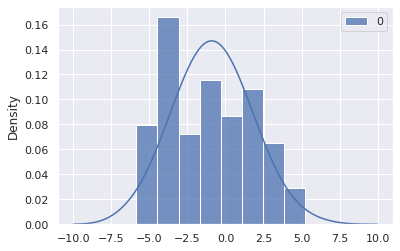

In [241]:
frame = 100
plt.plot(x, p[frame, :])
sns.histplot(X[frame, :], stat='density')

<AxesSubplot:>

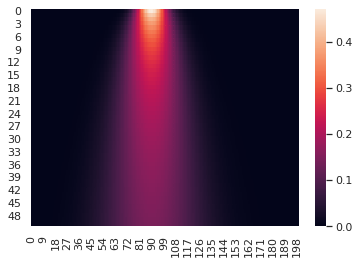

In [242]:
sns.heatmap(p)

In [243]:
def adv_diff(x, t, v, D, sigma0, x0):
    return  (2 * jnp.pi * sigma0 ** 2 + 4 * jnp.pi * D * t) ** (-1 / 2) * jnp.exp(
        -((x - x0 - v * t) ** 2) / (2 * sigma0 ** 2 + 4 * D * t)
    )

In [244]:
p_true = adv_diff(x_grid.squeeze(), jnp.ones_like(x_grid.squeeze()) * t, v, D, sigma0, x0)

<AxesSubplot:>

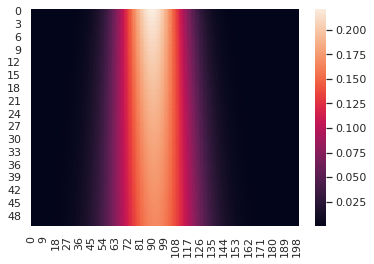

In [245]:
sns.heatmap(p_true)

In [246]:
p_true = adv_diff(x_grid.squeeze(), jnp.ones_like(x_grid.squeeze()) * t, v, D, sigma0, x0)

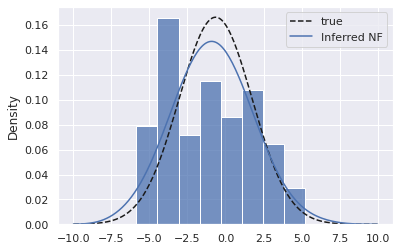

In [253]:
frame = 200
plt.plot(x, p_true[frame, :], 'k--', label='true')
plt.plot(x, p[frame, :], label='Inferred NF')
sns.histplot(X[frame, :], stat='density')
plt.legend()

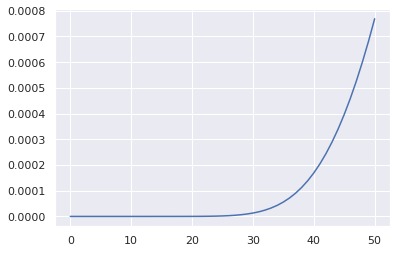

In [249]:
plt.plot(p[:, 10])